In [4]:
# Librairie
import os

import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error,mean_squared_error

from datetime import datetime

# Pre-processing

On importe les données sur les ventes 

In [6]:
'''
Import des fichiers de données
'''
chemin_fichier_csv = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('dionysos'))),'prevision', 'data')

attendancePath=chemin_fichier_csv + "/affluence.csv"
prevSellsPath=chemin_fichier_csv + "/data_vente.csv"
meteoPath=chemin_fichier_csv + "/archive.csv"

# Fichier des prévisions d'attendance
attendanceDf=pd.read_csv(attendancePath)[['date', 'phq_attendance_stats_sum']]
attendanceDf = attendanceDf.rename(columns={'phq_attendance_stats_sum': 'attendance'})

# Fichier des prévisions de ventes
prevSellsDf=pd.read_csv(prevSellsPath,sep=';')

# Fichier des prévisions météo
meteoDf=pd.read_csv(meteoPath)
# Ne pas prendre en compte les 3 premiere ligne du csv
meteoDf = meteoDf.iloc[3:]
# Renommer la colonne time en date
meteoDf = meteoDf.rename(columns={'time': 'date'})

meteoDf['date']=pd.to_datetime(meteoDf['date'], format='%Y-%m-%d')
attendanceDf['date']=pd.to_datetime(attendanceDf['date'], format='%Y-%m-%d')
prevSellsDf['date']=pd.to_datetime(prevSellsDf['date'], format='%d-%m-%Y')

# Concaténer les DataFrames en utilisant la colonne "date" comme clé de fusion
df = pd.merge(attendanceDf, prevSellsDf, on='date', how='outer')
df = pd.merge(df, meteoDf, on='date', how='outer')

# supprimer les lignes avec des valeurs manquantes 
df = df.dropna()

df.head()

,date,attendance,prevision,vente,apparent_temperature_mean (°C),rain_sum (mm),snowfall_sum (cm)
3,2023-03-06,18692.0,9000.0,7142.63,-7.5,0.0,0.00
4,2023-03-07,43576.0,14000.0,13997.38,-10.0,0.1,1.47
5,2023-03-08,29462.0,16000.0,18136.16,-7.5,0.0,0.00
6,2023-03-09,74643.0,22000.0,19975.51,-5.9,0.0,0.00
7,2023-03-10,69394.0,20000.0,18626.76,-8.2,0.0,0.00


In [132]:
# On ajoute une colonne 'Jour' qui contient le jour de la semaine
def date2day(date_str):
    '''
    Cette fonction permet de convertire une date en jour de la semaine
    correspondant
        * Input :  (Str) Date '%d-%m-%Y'
        * Output : (Str) Jour de la semaine
    '''
    # Obtention du jour de la semaine (0 = lundi, 1 = mardi, ..., 6 = dimanche)
    jour_semaine = date_str.weekday()
    return jour_semaine

df['day'] = df['date'].apply(date2day)

# hot encode day
df = pd.get_dummies(df, columns=['day'])
df.head()

,date,attendance,prevision,vente,apparent_temperature_mean (°C),rain_sum (mm),snowfall_sum (cm),day_0,day_1,day_2,day_3,day_4,day_5,day_6
3,2023-03-06,18692.0,9000.0,7142.63,-7.5,0.0,0.00,1,0,0,0,0,0,0
4,2023-03-07,43576.0,14000.0,13997.38,-10.0,0.1,1.47,0,1,0,0,0,0,0
5,2023-03-08,29462.0,16000.0,18136.16,-7.5,0.0,0.00,0,0,1,0,0,0,0
6,2023-03-09,74643.0,22000.0,19975.51,-5.9,0.0,0.00,0,0,0,1,0,0,0
7,2023-03-10,69394.0,20000.0,18626.76,-8.2,0.0,0.00,0,0,0,0,1,0,0


/Users/mac2021/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


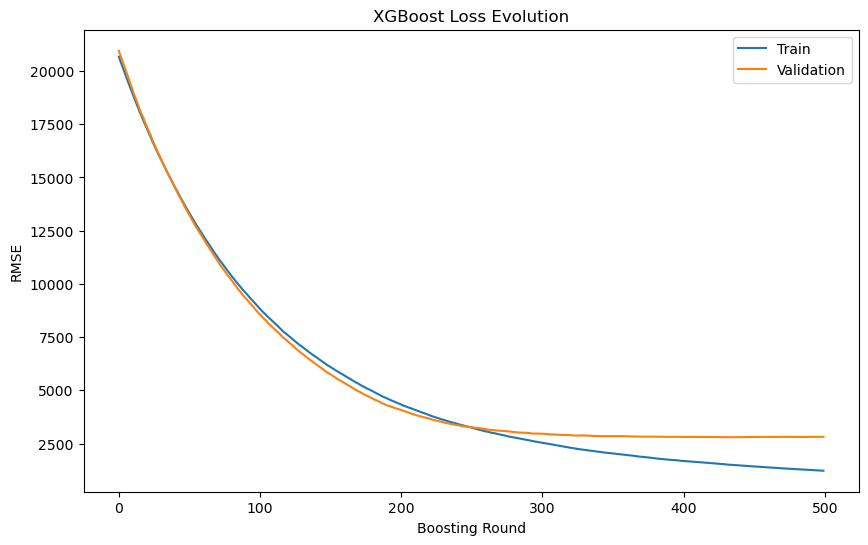

In [133]:
X = df.drop(['vente','date','attendance'], axis=1)
y = df['vente']


# segmente les données d'entrainement et de validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=7)
prevision_cage = X_test['prevision'].tolist()

# Supprimer la colonne prevision
X_train = X_train.drop(['prevision'], axis=1)
X_test = X_test.drop(['prevision'], axis=1)

model = xgb.XGBRegressor(
    n_estimators=500,  # Number of trees (boosting rounds)
    max_depth=15,  # Maximum depth of each tree
    learning_rate=0.01,  # Step size shrinkage
    subsample=0.6,  # Subsample ratio of the training instances
    colsample_bytree=0.6,  # Subsample ratio of columns when constructing each tree
    objective='reg:squarederror'  # Loss function to be minimized
)

# affoc
# Train the model en affichant la courbe d'apprentissage
model.fit( X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric='rmse', verbose=False)

results = model.evals_result()
train_loss = results['validation_0']['rmse']
val_loss = results['validation_1']['rmse']
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Validation')
plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.title('XGBoost Loss Evolution')
plt.legend()
plt.show()



In [134]:
# Evaluate the model
# Make predictions
predictions = model.predict(X_test)

print("Notre prevision : Mean Absolute Error : " + str(mean_absolute_error(predictions, y_test)))
print("Prévision cage : Mean Absolute Error : " + str(mean_absolute_error(prevision_cage, y_test)))


Notre prevision : Mean Absolute Error : 2396.6169067382807
Prévision cage : Mean Absolute Error : 2388.2906249999996


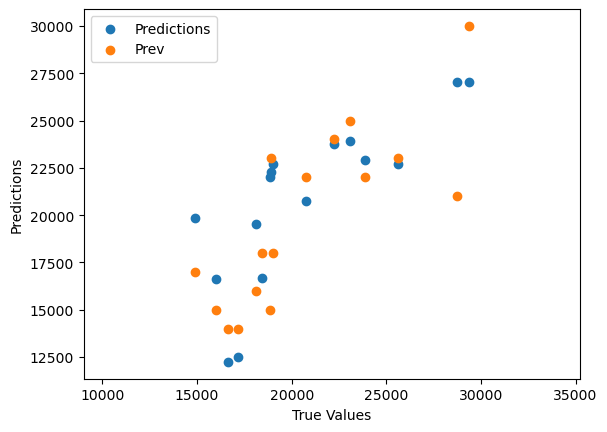

In [135]:
# plot les prédictions en fonction des valeurs réelles
plt.scatter(y_test, predictions)
plt.scatter(y_test, prevision_cage)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.legend(['Predictions', 'Prev'])
plt.axis('equal')
plt.show()

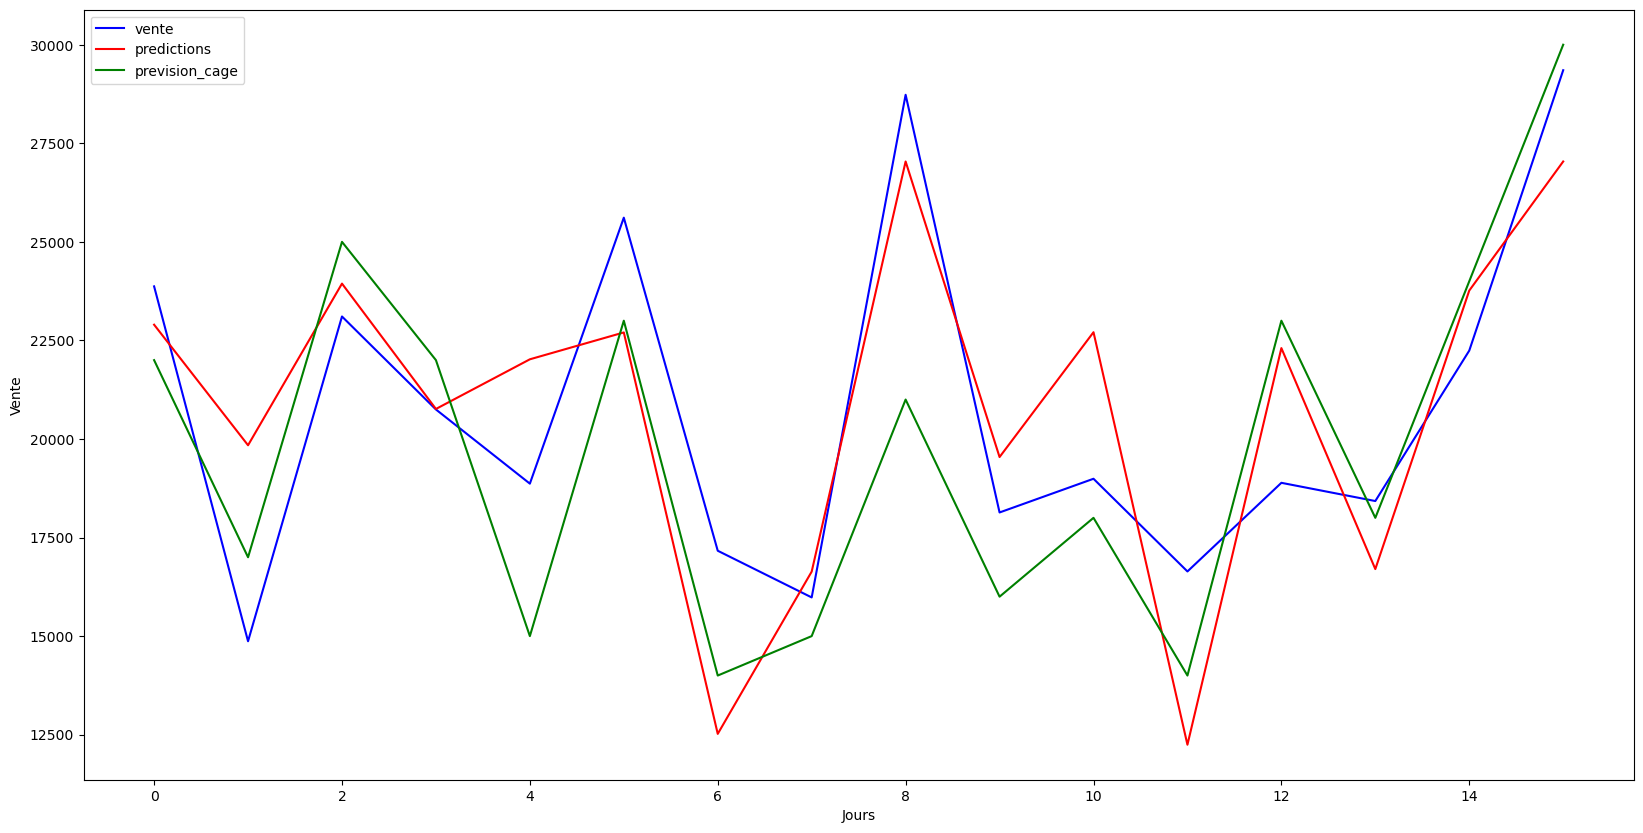

In [136]:
plt.figure(figsize=(20,10))
plt.plot(y_test.tolist(), color='blue',label='vente')
plt.plot(predictions, color='red',label='predictions')
plt.plot(prevision_cage, color='green',label='prevision_cage')
plt.xlabel('Jours')
plt.ylabel('Vente')
plt.legend()
plt.show()

Test à faire: 

* Faire grid sheet avec les données de ventes
* Voir l'impact des variables 

In [137]:
# Définir les hyperparamètres à tester
param_grid = {
    'n_estimators': [10,100, 200, 500, 1000],
    'max_depth': [5,10, 15,25,50,100],
    'learning_rate': [ 0.5, 0.1,0.075 ,0.05,0.025 ,0.01, 0.001],
    'subsample': [0.2 , 0.4 ,0.6, 0.8, 1.0],
    'colsample_bytree': [0.2 , 0.4 ,0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.5, 1.0],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.01, 0.1, 1.0],
    'reg_lambda': [0, 0.01, 0.1, 1.0]
}

# Créer le modèle XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror')

# Créer l'objet GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_root_mean_squared_error')

# Effectuer la recherche par grille sur les données d'entraînement avec un indicatif de progression
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres trouvés
print("Meilleurs paramètres :", grid_search.best_params_)

# Obtenir le meilleur modèle entraîné
best_model = grid_search.best_estimator_

# Évaluer le modèle sur les données de test
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE sur les données de test :", rmse)

KeyboardInterrupt: 